# Using XT3D for More Accurate Flows on an Unstructured Grid

In this notebook we'll demonstrate the improved accuracy XT3D can provide in flow simulations on unstructured grids. The DISV grid in this example is a rectangular grid with an area of quadtree refinement in the middle. The connections between cells of different sizes violate the CVFD requirements, rendering the standard, conductance-based flow formulation less accurate.

This notebook is based on the MODFLOW 6 "Nested Grid" ([ex-gwf-u1disv](https://modflow6-examples.readthedocs.io/en/latest/_examples/ex-gwf-u1disv.html)) example problem, which corresponds to the first example described in the MODFLOW-USG documentation.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import os
import pathlib as pl

import flopy
import flopy.utils.cvfdutil
import matplotlib.pyplot as plt
import numpy as np
from flopy.plot.styles import styles

root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
path_to_mf6 = "mf6"

# Settings from environment variables
write = True
run = True
plot = True
plot_show = True
plot_save = True

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Model units
length_units = "meters"
time_units = "days"

# Scenario-specific parameters
parameters = {
    "ex-gwf-u1disv": {
        "xt3d": False,
    },
    "ex-gwf-u1disv-x": {
        "xt3d": True,
    },
}

# Model parameters
nper = 1  # Number of periods
nlay = 1  # Number of layers
top = 0.0  # Top of the model ($m$)
botm = -100.0  # Layer bottom elevations ($m$)
strt = 0.0  # Starting head ($m$)
icelltype = 0  # Cell conversion type
k11 = 1.0  # Horizontal hydraulic conductivity ($m/d$)

# Static temporal data used by TDIS file
# Simulation has 1 steady stress period (1 day)
# and 3 transient stress periods (10 days each).
# Each transient stress period has 120 2-hour time steps.
perlen = [1.0]
nstp = [1]
tsmult = [1.0, 1.0, 1.0]
tdis_ds = list(zip(perlen, nstp, tsmult))

# create the disv grid
# outer grid
nlay = 1
nrow = ncol = 7
delr = 100.0 * np.ones(ncol)
delc = 100.0 * np.ones(nrow)
tp = np.zeros((nrow, ncol))
bt = -100.0 * np.ones((nlay, nrow, ncol))
idomain = np.ones((nlay, nrow, ncol))
idomain[:, 2:5, 2:5] = 0
sg1 = flopy.discretization.StructuredGrid(
    delr=delr, delc=delc, top=tp, botm=bt, idomain=idomain
)
# inner grid
nlay = 1
nrow = ncol = 9
delr = 100.0 / 3.0 * np.ones(ncol)
delc = 100.0 / 3.0 * np.ones(nrow)
tp = np.zeros((nrow, ncol))
bt = -100 * np.ones((nlay, nrow, ncol))
idomain = np.ones((nlay, nrow, ncol))
sg2 = flopy.discretization.StructuredGrid(
    delr=delr,
    delc=delc,
    top=tp,
    botm=bt,
    xoff=200.0,
    yoff=200,
    idomain=idomain,
)

# get the disv grid arguments
gridprops = flopy.utils.cvfdutil.gridlist_to_disv_gridprops([sg1, sg2])

# Solver parameters
nouter = 50
ninner = 100
hclose = 1e-9
rclose = 1e-6

### Model setup

Define functions to build models, write input files, and run the simulation.

In [4]:
def build_models(sim_name, xt3d):
    sim_ws = os.path.join(workspace, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name=path_to_mf6)
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        linear_acceleration="bicgstab",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name, save_flows=True)
    flopy.mf6.ModflowGwfdisv(
        gwf,
        length_units=length_units,
        nlay=nlay,
        top=top,
        botm=botm,
        **gridprops,
    )
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k11,
        save_specific_discharge=True,
        xt3doptions=xt3d,
    )
    flopy.mf6.ModflowGwfic(gwf, strt=strt)

    chd_spd = []
    chd_spd += [[0, i, 1.0] for i in [0, 7, 14, 18, 22, 26, 33]]
    chd_spd = {0: chd_spd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_spd,
        pname="CHD-LEFT",
        filename=f"{sim_name}.left.chd",
    )

    chd_spd = []
    chd_spd += [[0, i, 0.0] for i in [6, 13, 17, 21, 25, 32, 39]]
    chd_spd = {0: chd_spd}
    flopy.mf6.ModflowGwfchd(
        gwf,
        stress_period_data=chd_spd,
        pname="CHD-RIGHT",
        filename=f"{sim_name}.right.chd",
    )

    head_filerecord = f"{sim_name}.hds"
    budget_filerecord = f"{sim_name}.cbc"
    flopy.mf6.ModflowGwfoc(
        gwf,
        head_filerecord=head_filerecord,
        budget_filerecord=budget_filerecord,
        saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],
    )

    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


def run_models(sim, silent=False):
    success, buff = sim.run_simulation(silent=silent, report=True)
    assert success, buff


# ### Plotting results
#
# Define functions to plot model results.

In [5]:
# Figure properties
figure_size = (6, 6)


def plot_grid(idx, sim):
    with styles.USGSMap():
        sim_name = list(parameters.keys())[idx]
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=figure_size)
        fig.tight_layout()

        ax = fig.add_subplot(1, 1, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid()
        pmv.plot_bc(name="CHD-LEFT", alpha=0.75)
        pmv.plot_bc(name="CHD-RIGHT", alpha=0.75)
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        for i, (x, y) in enumerate(
            zip(gwf.modelgrid.xcellcenters, gwf.modelgrid.ycellcenters)
        ):
            ax.text(
                x,
                y,
                f"{i + 1}",
                fontsize=6,
                horizontalalignment="center",
                verticalalignment="center",
            )
        v = gwf.disv.vertices.array
        ax.plot(v["xv"], v["yv"], "yo")
        for i in range(v.shape[0]):
            x, y = v["xv"][i], v["yv"][i]
            ax.text(
                x,
                y,
                f"{i + 1}",
                fontsize=5,
                color="red",
                horizontalalignment="center",
                verticalalignment="center",
            )

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            fig.savefig(fpth)


def plot_head(idx, sim):
    with styles.USGSMap():
        sim_name = list(parameters.keys())[idx]
        sim_ws = os.path.join(workspace, sim_name)
        gwf = sim.get_model(sim_name)

        fig = plt.figure(figsize=(7.5, 5))
        fig.tight_layout()

        head = gwf.output.head().get_data()[:, 0, :]

        # create MODFLOW 6 cell-by-cell budget object
        qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
            gwf.output.budget().get_data(text="DATA-SPDIS", totim=1.0)[0],
            gwf,
        )

        ax = fig.add_subplot(1, 2, 1, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid()
        cb = pmv.plot_array(head, cmap="jet")
        pmv.plot_vector(
            qx,
            qy,
            normalize=False,
            color="0.75",
        )
        cbar = plt.colorbar(cb, shrink=0.25)
        cbar.ax.set_xlabel(r"Head, ($m$)")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        styles.heading(ax, letter="A", heading="Simulated Head")

        ax = fig.add_subplot(1, 2, 2, aspect="equal")
        pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0)
        pmv.plot_grid()
        x = np.array(gwf.modelgrid.xcellcenters) - 50.0
        slp = (1.0 - 0.0) / (50.0 - 650.0)
        heada = slp * x + 1.0
        cb = pmv.plot_array(head - heada, cmap="jet")
        cbar = plt.colorbar(cb, shrink=0.25)
        cbar.ax.set_xlabel(r"Error, ($m$)")
        ax.set_xlabel("x position (m)")
        ax.set_ylabel("y position (m)")
        styles.heading(ax, letter="B", heading="Error")

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-head.png"
            fig.savefig(fpth)


def plot_results(idx, sim, silent=True):
    if idx == 0:
        plot_grid(idx, sim)
    plot_head(idx, sim)

### Running the example

Define and invoke a function to run the example scenario, then plot results.

In [6]:
def simulation(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)
    if plot:
        plot_results(idx, sim, silent=silent)

Run the USG1DISV model without XT3D, then plot heads.

C:\Users\aprovost\AppData\Local\miniforge3\envs\mfandmore2024\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\aprovost\AppData\Local\miniforge3\envs\mfandmore2024\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
C:\Users\aprovost\AppData\Local\miniforge3\envs\mfandmore2024\Lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


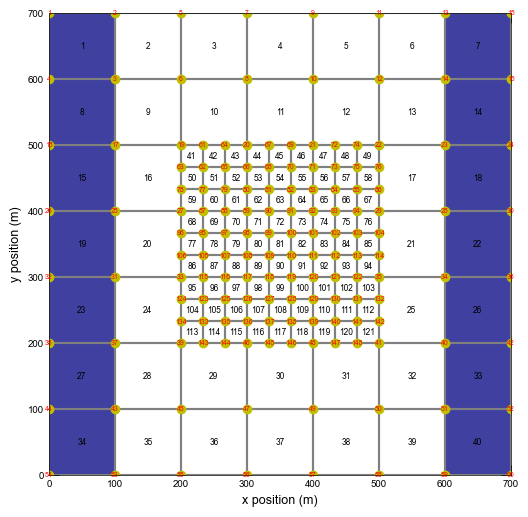

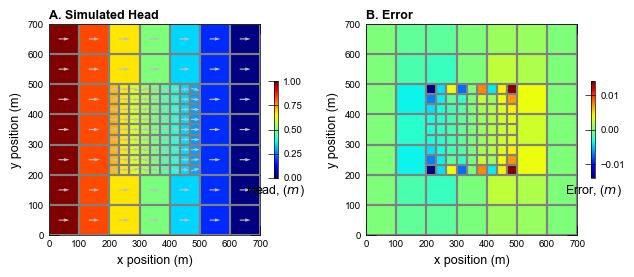

In [7]:
simulation(0)

Run the USG1DISV model with XT3D, then plot heads.

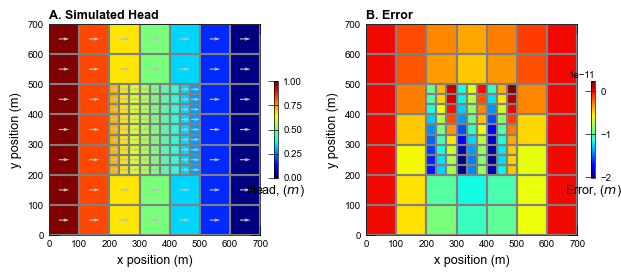

In [8]:
simulation(1)